# Assignment 4 - Advanced Hyperparameter Tuning

In [1]:
import random
import pandas as pd
import keras
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

2025-12-21 15:36:11.824053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766331372.844074    3872 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766331373.144194    3872 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766331375.924518    3872 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766331375.924546    3872 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766331375.924548    3872 computation_placer.cc:177] computation placer alr

In [2]:
# load data
sym_dim=8
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train = X_train.reshape(-1, 28 * 28).astype("float32") / 255.0 #this is how we normally scale with images
X_test = X_test.reshape(-1, 28 * 28).astype("float32") / 255.0 #same for test


X_train = resize(X_train.reshape(-1, 28, 28), (len(X_train), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")
X_test = resize(X_test.reshape(-1, 28, 28), (len(X_test), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Classes: {np.unique(y_train)}")

X_train: (60000, 64), y_train: (60000,)
X_test: (10000, 64), y_test: (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]


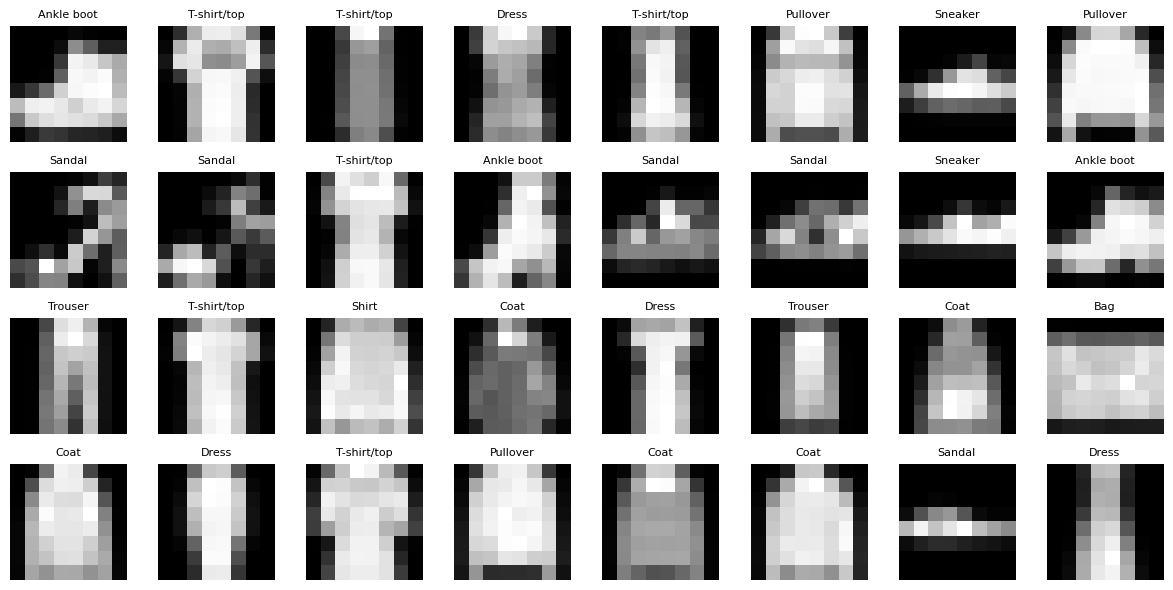

In [3]:
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(sym_dim, sym_dim), cmap='gray')
    ax.set_title(class_names[y_train[i]], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
def eval_model(model, X_test, y_test, model_name=None):
    """Evaluate model on test data and print summary."""
    from sklearn.metrics import r2_score
    
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    r2 = r2_score(y_test, y_pred)
    
    if model_name:
        print(f"\n{'='*50}")
        print(f"  {model_name} - Test Results")
        print(f"{'='*50}")
    else:
        print(f"\n{'='*50}")
        print(f"  Test Results")
        print(f"{'='*50}")
    
    print(f"  Test Loss (MSE): {test_loss:,.2f}")
    print(f"  Test MAE:        {test_mae:.2f}")
    print(f"  R² Score:        {r2:.4f} ({r2*100:.2f}% variance explained)")
    print(f"{'='*50}\n")
    
    return test_loss, test_mae, r2

def eval_classification(model: keras.Model, X_test: np.ndarray, y_test: np.ndarray, class_names: list[str] = None, model_name: str = None):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    
    print(f"\n{'='*50}")
    print(f"  {model_name or 'Model'} - Classification Results")
    print(f"{'='*50}")
    print(f"  Test Loss:     {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"{'='*50}\n")
    
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f"{model_name or 'Model'} - Confusion Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Exercise 1: Extended Random Search

### Part (a) Extending the Hyperparameter search

In [21]:
def create_fcnn(
    input_dim: int,
    num_classes: int,
    hidden_layers: list[int] = [512, 256, 128],
    dropout_rate: float = 0.3,
    learning_rate: float = 0.1,
    activation_function: str = "relu",
    name: str = "fcnn"
) -> keras.Model:
    
    inputs = keras.layers.Input(shape=(input_dim,))
    x = inputs
    
    for _, units in enumerate(hidden_layers):
        x = keras.layers.Dense(units)(x)
        x = keras.layers.Activation(activation_function)(x)
        if dropout_rate > 0:
            x = keras.layers.Dropout(dropout_rate)(x)
    
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def train_model(model, X_train, y_train, model_name, epochs=50, batch_size=32, early_stopping=True, patience=50, verbose = 1):
    
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    callbacks = [callback]
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )
    
    return model, history

To optimize the **search strategy** I decided to use the Hyperband approach that is described here https://www.blog.trainindata.com/the-ultimate-guide-to-deep-learning-hyperparameter-tuning/ as it performs better than random search but does not require many adaptions to the code that has been provided. 

I decided to train a model per hyperparameter setting with an epoch of 1 for the first "stage". Then, for the next stage, I half the amount of hyperparameter settings and train the remaining top 50 models with 5 epochs. The last round I train 25 models with 20 epochs.

I tried some different values for the epochs and figured that with these numbers, the execution doesn't take too long but achieves good results. 

In [30]:
def create_hyperparams(
    n: int,
    num_layers_range: tuple[int, int] = (1, 4),
    units_choices: list[int] = [128, 256, 512],
    dropout_range: tuple[float, float] = (0.1, 0.5),
    lr_range: tuple[float, float] = (0.001, 0.1),
    activation_func_choices: list[str] = ["sigmoid", "relu"],
    batch_size_range: tuple[int, int] = (4, 8)
) -> pd.DataFrame:
    
    params_list = []
    for _ in range(n):
        params_list.append({
            "hidden_layers": [random.choice(units_choices) for _ in range(random.randint(*num_layers_range))],
            "dropout_rate": round(random.uniform(*dropout_range), 3),
            "learning_rate": round(random.uniform(*lr_range), 3),
            "activation_function": random.choice(activation_func_choices),
            "batch_size": 2**random.randint(*batch_size_range)
        })
    return pd.DataFrame(params_list)


def run_search(
    hp_df: pd.DataFrame,
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: tuple[int, int, int] = (1, 5, 20),
) -> tuple[keras.Model, dict, pd.DataFrame]:
    
    candidates = hp_df.copy() # top hyperparameter settings
    candidates["val_acc"] = -1.0
    results = hp_df.copy()
    results["val_acc"] = -1.0
    models = {}
    
    for stage, ep in enumerate(epochs): 
        models = {}
        for i, row in candidates.iterrows():
            #n_iteration = len(candidates)*2*stage + i
            params = {
                "hidden_layers": row["hidden_layers"],
                "dropout_rate": row["dropout_rate"],
                "learning_rate": row["learning_rate"],
                "activation_function": row["activation_function"] # batch size needs to be passed in train_model
            }
           
            model = create_fcnn(input_dim=X_train.shape[1], num_classes=10, name=f"trial_{i}_stage_{stage}", **params)
            
            layers_str = "_".join(map(str, params["hidden_layers"]))
            model_name = f"rs_L{layers_str}_D{int(params['dropout_rate'])}_LR{params['learning_rate']}_ActFunc{params['activation_function']}_B{row['batch_size']}"
            
            # use actual validation dataset of train_model to get validation accuracy 
            model, history = train_model(model, X_train, y_train, model_name=model_name, epochs=ep, batch_size=row["batch_size"], early_stopping=True, verbose=0)
            val_acc = max(history.history["val_accuracy"])
            
            results.loc[i, "val_acc"] = round(val_acc, 4)
            models[i] = model
            
            print(f"Trial {i+1}/{len(candidates)}, stage {stage}: acc={val_acc:.4f}")
        
        results = results.sort_values("val_acc", ascending=False).reset_index(drop=True)
        best_idx = results.iloc[0].name if "name" in dir(results.iloc[0]) else 0

        # Keep top performers, always make sure at least 1, otherwise half the models
        candidates = results.head(max(1, int(len(candidates) * 0.5)))
    
    print(f"\n✓ Best: val_acc={results.iloc[0]['val_acc']:.4f}")
    return models[hp_df.index[results.index[best_idx]]], results.iloc[0].to_dict(), results

For the **hyperparameters** to tune i chose: 
* hidden layers
* dropout rate
* learning rate 
* activation function 
* batch size

**hidden layers**:
This parameter was already given, I added 64 also as choice of nodes of a layer because at the previous homework it showed that smaller numbers of neurons often produce better results. 
I expect this parameter to have the highest impact on the solution. 

**dropout rate**:
I changed the range from 0.0-0.5 to 0.0-0.4 because a dropout rate of 50% seemed to high for me. At the previous homework, the value for this parameter didn't matter much for the result. 

**learning rate**:
This parameter is also easy to tune, similar to the 2 given hyperparameters and can affect the result heavily. 
I opted for a range of 0.001 to 0.1, because previous optimizations showed that lower values for the learning rate are preferred.

**activation function**: 
I chose to optimize this parameter as I expect it to have a big impact on the final solution. Based on what has been taught in this course so far, I expect the ReLU-function to do best or one of its modifications ELU or leaky ReLU. To select the different functions to choose from, I had a look at the ones provided by keras on https://keras.io/api/layers/activations/ and picked those that we already heard about in the lecture.

**batch size**: 
For this parameter I chose to pass integer values that will be computed as powers of 2 as the batch size normally is a value of power of 2. I don't expect a huge impact of this value on the result, it will probably have more impact on the time that the training takes. 

In [27]:
hp_df = create_hyperparams(
    n=100,
    num_layers_range=(1, 4),
    units_choices=[64, 128, 256, 512],
    dropout_range=(0.0, 0.4),
    lr_range=(0.001, 0.1),
    activation_func_choices=["sigmoid", "relu", "elu", "leaky_relu", "tanh"], # activation functions from https://keras.io/api/layers/activations/
    batch_size_range=(4, 8) # values will be 2**x -> from 2^4 to 2^8 (including both ends)
)
hp_df

,hidden_layers,dropout_rate,learning_rate,activation_function,batch_size
0,[128],0.092,0.017,elu,256
1,[512],0.155,0.040,tanh,16
2,[512],0.331,0.005,tanh,128
3,"[256, 256, 64, 128]",0.348,0.018,sigmoid,32
4,"[256, 64, 256]",0.219,0.008,leaky_relu,128
...,...,...,...,...,...
95,"[512, 256]",0.027,0.046,leaky_relu,32
96,"[256, 512, 128]",0.346,0.056,elu,32
97,"[128, 256, 128]",0.396,0.019,sigmoid,32
98,[256],0.324,0.030,relu,128


In [31]:
best_model, best_params, results_df = run_search(hp_df, X_train, y_train)
results_df

Trial 1/100, stage 0: acc=0.7953
Trial 2/100, stage 0: acc=0.6532
Trial 3/100, stage 0: acc=0.7918
Trial 4/100, stage 0: acc=0.1003
Trial 5/100, stage 0: acc=0.8012
Trial 6/100, stage 0: acc=0.7364
Trial 7/100, stage 0: acc=0.0995
Trial 8/100, stage 0: acc=0.6323
Trial 9/100, stage 0: acc=0.2662
Trial 10/100, stage 0: acc=0.3004
Trial 11/100, stage 0: acc=0.6862
Trial 12/100, stage 0: acc=0.1030
Trial 13/100, stage 0: acc=0.6655
Trial 14/100, stage 0: acc=0.1005
Trial 15/100, stage 0: acc=0.7865
Trial 16/100, stage 0: acc=0.6173
Trial 17/100, stage 0: acc=0.7843
Trial 18/100, stage 0: acc=0.2012
Trial 19/100, stage 0: acc=0.7025
Trial 20/100, stage 0: acc=0.6064
Trial 21/100, stage 0: acc=0.6969
Trial 22/100, stage 0: acc=0.6982
Trial 23/100, stage 0: acc=0.0957
Trial 24/100, stage 0: acc=0.5905
Trial 25/100, stage 0: acc=0.7198
Trial 26/100, stage 0: acc=0.7695
Trial 27/100, stage 0: acc=0.2022
Trial 28/100, stage 0: acc=0.5727
Trial 29/100, stage 0: acc=0.2016
Trial 30/100, stage 0: 

,hidden_layers,dropout_rate,learning_rate,activation_function,batch_size,val_acc
0,"[128, 256]",0.031,0.003,leaky_relu,64,0.8695
1,"[256, 128]",0.182,0.005,leaky_relu,128,0.8649
2,"[128, 64, 64]",0.095,0.008,relu,128,0.8648
3,[128],0.139,0.038,sigmoid,128,0.8627
4,[128],0.338,0.009,relu,128,0.8580
...,...,...,...,...,...,...
95,"[128, 512, 64, 256]",0.248,0.020,sigmoid,256,0.0983
96,"[64, 512]",0.287,0.083,sigmoid,256,0.0957
97,"[512, 512, 64]",0.021,0.075,sigmoid,64,0.0957
98,"[256, 64, 256, 512]",0.134,0.033,relu,256,0.0957


In [33]:
best_params

{'hidden_layers': [128, 256],
 'dropout_rate': 0.031,
 'learning_rate': 0.003,
 'activation_function': 'leaky_relu',
 'batch_size': 64,
 'val_acc': 0.8695}

In [32]:
best_model.summary()

Model: "trial_0_stage_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_226 (InputLayer)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_779 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_553 (Activation)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_553 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_780 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,832 (112.63 KB)

 Trainable params: 9,610 (37.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,222 (75.09 KB)


  Fashion FCNN - Classification Results
  Test Loss:     0.4111
  Test Accuracy: 0.8525 (85.25%)

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.84      0.81      1000
     Trouser       0.96      0.95      0.95      1000
    Pullover       0.75      0.72      0.73      1000
       Dress       0.87      0.85      0.86      1000
        Coat       0.74      0.79      0.76      1000
      Sandal       0.97      0.93      0.95      1000
       Shirt       0.66      0.59      0.62      1000
     Sneaker       0.93      0.92      0.93      1000
         Bag       0.97      0.96      0.96      1000
  Ankle boot       0.91      0.96      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



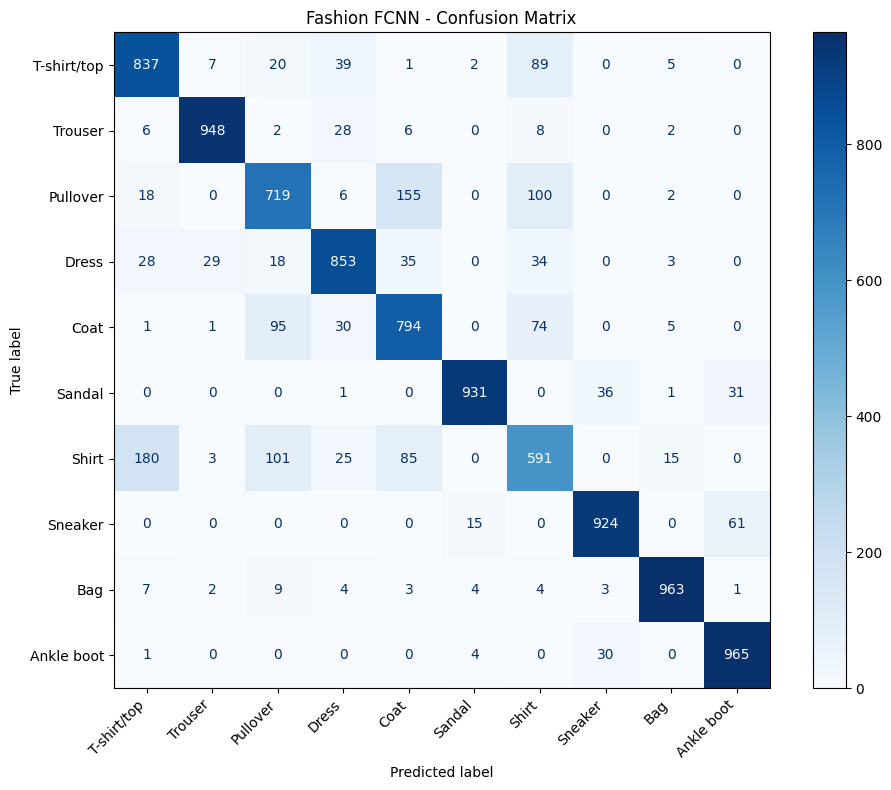

In [37]:
eval_classification(best_model, X_test, y_test, class_names, "Fashion FCNN")

#### Conclusion

The model that performed best had these hyperparameters with an validation accuracy of 0.8695: 
* hidden_layers: [128, 256],
* dropout_rate: 0.031,
* learning_rate: 0.003,
* activation_function: 'leaky_relu',
* batch_size: 64

When comparing the best 5 models with the worst 5 models, I noticed these differences: 
* Only one of the best models has 3 hidden layers, whereas 3 out of the 5 models at the bottom have 4 hidden layers. This indicates that even models with only one hidden layer perform better on this dataset than models with higher amounts of layers.
* It seems like 512 neurons are too many, as in the first 5 models there is no hidden layer with that many nodes, 128 appears the most
* The dropout-rate does not influence the result much, the value for this parameter varies heavily. 
* For the learning rate lower values are preferred, in the top five, four models have a learning rate <= 0.009
* As activation function the Leaky ReLU and ReLU lead to the best results. In the bottom five models you can find the sigmoid, the tanh and the ReLU only once. 
* The batch size of the best models is either 64 or 128. Smaller batch sizes (16), but also larger batch sizes (256) perform worse. 

### Part (b) Fixing the Data Leak

There is a problem in the initial code to train the model: 
```python
model, _ = train_model(model, X_train, y_train, model_name=model_name, epochs=epochs, early_stopping=True, verbose=0)
_, val_acc = model.evaluate(X_train[:10000], y_train[:10000], verbose=0)
```
The model is trained on the whole X_train and y_train datasets, so the accuracy that is computed is not truly the validation accuracy. The model was trained on the data that it is tried to evaluate upon. 

In order to fix this data leak, I just extracted the value of the validation accuracy from the history that is returned from ```train_model```. This is possible since in this method the model is trained with a validation_split of 20%. 
```python
model, history = train_model(model, X_train, y_train, model_name=model_name, epochs=epochs, early_stopping=True, verbose=0)
val_acc = max(history.history["val_accuracy"])
```

## Exercise 2: Keras Tuner

As I tried to implement Hyperband Optimization by hand in exercise 1, I chose to use Bayesian Optimization to see how this performs on this dataset. 

### Bayesian Optimization 

The search starts by evaluating at random a few hyperparameter value combinations. With the model performance values obtained from the different combinations, it builds a probabilistic model and then finds the combinations that worked best. After that, it samples combinations sequentially, looking around those values that returned the best model performance, or alternatively, values that have not been explored yet. 

Bayesian Optimization balances exploration and exploitation. 

I found this description on the same website as above: 
https://www.blog.trainindata.com/the-ultimate-guide-to-deep-learning-hyperparameter-tuning/

In [ ]:
#%pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras-tuner]
Note: you may need to restart the kernel to use updated packages.


In [5]:
import keras_tuner

In [10]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(X_train.shape[1],)))
  n_hidden_layers = hp.Int("n_layers", min_value=1, max_value=4) # choose number of hidden layers
  activation_function = hp.Choice('activation', ["sigmoid", "relu", "elu", "leaky_relu", "tanh"]) # choose activation function
  dropout = hp.Float("dropout_rate", min_value=0.0, max_value=0.4, step=0.01) # choose dropout rate
  for _ in range(n_hidden_layers):
    model.add(keras.layers.Dense(
        hp.Choice('units', [64, 128, 256, 512]), # choose number of neurons
        activation=activation_function))
    if dropout > 0:
      model.add(keras.layers.Dropout(dropout))

  hp.Int("batch_size", min_value=16, max_value=256, step=2, sampling="log") # choose batch size, will automatically be sampled when calling fit
  
  model.add(keras.layers.Dense(10, activation="softmax")) # output layer
  opt = keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=0.001, max_value=0.1, step=0.001)) # choose learning rate
  model.compile(
      optimizer=opt,
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"]
  )
  return model

In [14]:
# I copied the parameter values from the keras documentation
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=100, # try 100 hyperparameter configurations
    num_initial_points=None,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    overwrite=True
)

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)


Trial 38 Complete [00h 00m 31s]
val_accuracy: 0.7458333373069763

Best val_accuracy So Far: 0.8588333129882812
Total elapsed time: 00h 23m 15s



Search: Running Trial #39

Value             |Best Value So Far |Hyperparameter
1                 |4                 |n_layers
elu               |tanh              |activation
0.21              |0                 |dropout_rate
256               |64                |units
256               |16                |batch_size
0.001             |0.001             |learning_rate

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6838 - loss: 0.9285 - val_accuracy: 0.7876 - val_loss: 0.5947
Epoch 2/10
 320/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7810 - loss: 0.5857

KeyboardInterrupt: 

In [16]:
best_model = tuner.get_best_models()[0]

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,290 (67.54 KB)

 Trainable params: 17,290 (67.54 KB)

 Non-trainable params: 0 (0.00 B)


  Fashion FCNN - Classification Results
  Test Loss:     0.4056
  Test Accuracy: 0.8513 (85.13%)

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.78      0.79      1000
     Trouser       0.97      0.94      0.95      1000
    Pullover       0.80      0.70      0.74      1000
       Dress       0.88      0.86      0.87      1000
        Coat       0.74      0.80      0.77      1000
      Sandal       0.98      0.89      0.93      1000
       Shirt       0.62      0.66      0.64      1000
     Sneaker       0.89      0.97      0.92      1000
         Bag       0.93      0.98      0.96      1000
  Ankle boot       0.95      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



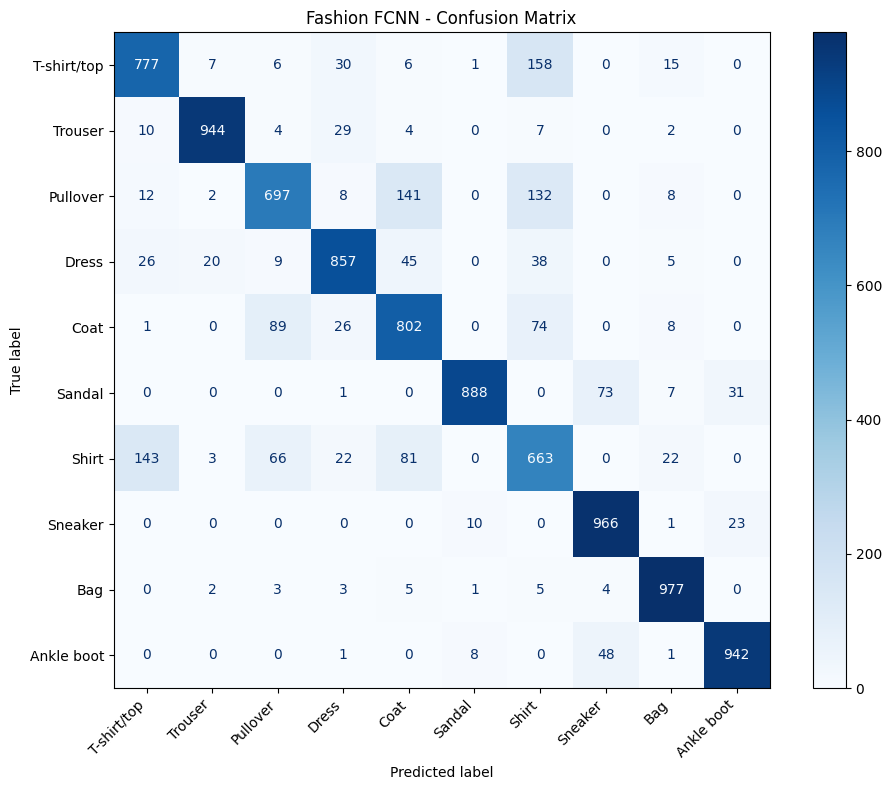

In [20]:
eval_classification(best_model, X_test, y_test, class_names, "Fashion FCNN")

### Conclusion & Comparison to Exercise 1

I wanted to make 100 trials, meaning training with 100 different hyperparameter settings as we did in exercise 1, but the execution took too long so I stopped it after 20 min.

The best model of this exercise had a test accuracy of 0.8513, the test accuracy of the best model of exercise 1 was slightly better with 0.8525 .

The parameters of the best model are a little bit surprising to me because they are very different to the best parameters of exercise 1: 
* number of hidden layers: 4
* neurons per layer: 64
* activation function: tanh
* dropout rate: 0
* batch size: 16
* learning rate: 0.001

*Is such an approach inherently better than random search with additional manual tuning?*

This approach is better when you want to try different optimizers, but in terms of execution speed and prediction accuracy the manual tuning worked better in my case. Maybe another optimizer would not take as long as the Bayesian Optimizer.  